In [1]:
import numpy
import pandas

from matplotlib import animation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
data = pandas.read_csv('customers.csv')

In [3]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Let's check for nulls

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


No nulls, looks good.

Let's check for outlier/strange values.

In [5]:
data.describe().round(2)

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.00,200.00,200.00,200.00
mean,100.50,38.85,60.56,50.20
std,57.88,13.97,26.26,25.82
min,1.00,18.00,15.00,1.00
25%,50.75,28.75,41.50,34.75
50%,100.50,36.00,61.50,50.00
75%,150.25,49.00,78.00,73.00
max,200.00,70.00,137.00,99.00


Numeric data seems reasonable at a glance.

In [6]:
data['CustomerID'].duplicated().sum()

0

No duplicated customerIDs either

In [7]:
data['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

And categorical data looks fine as well.

We are going to run kmeans just on our numeric data. Just 3 dimensions will be nicer to plot as well.  
First we need to standardise our data.

In [8]:
X = StandardScaler().fit_transform(data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

C:\Users\James\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\James\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


To select k for kmeans, we will eyeball a value from a silhouette coefficient plot.  
Generally speaking, we want a high silhouette coefficient, and preferable lower number of clusters.

In [9]:
silh_scores = []
for num_clusters in range(2, 15):
    kmeans = KMeans(n_clusters = num_clusters,  random_state = 50).fit(X)
    score = silhouette_score(X, kmeans.fit_predict(X))
    
    silh_scores.append(score)

In [10]:
ax = pandas.DataFrame(data=silh_scores, index=range(2,15)).plot(marker='o', legend=False, figsize=(12,6))
ax.set(xlabel='Number of Clusters', ylabel='Silhouette Coefficient')

[Text(0, 0.5, 'Silhouette Coefficient'), Text(0.5, 0, 'Number of Clusters')]

From this we will pick k = 6

In [11]:
NUM_CLUSTERS = 6

kmeans = KMeans(n_clusters = NUM_CLUSTERS,  random_state = 50).fit(X)
cluster_preds = kmeans.fit_predict(X)

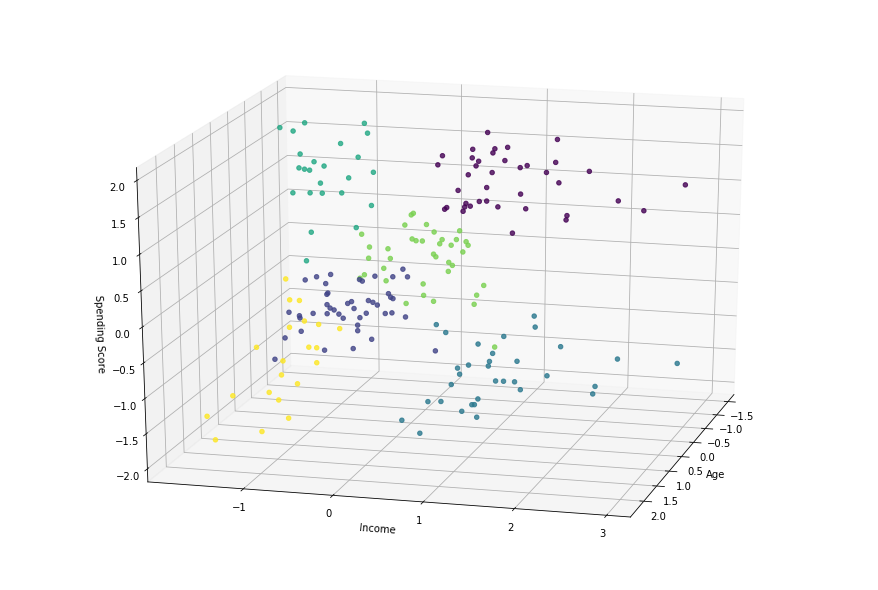

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig)
C = kmeans.cluster_centers_
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=kmeans.labels_, alpha=0.8)

ax.view_init(elev=20, azim=15)
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Spending Score')

plt.show()

In [13]:
def rotate(angle):
    ax.view_init(azim=angle)

rot_animation = animation.FuncAnimation(fig, rotate, frames=numpy.arange(0, 362, 4), interval=100)
rot_animation.save('rotation.gif', dpi=80)

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


Looking at the graph and the animation, our data has been clustered fairly well.

So then we can look some mean statistics for each cluster without fear of losing too much granularity.  
Let's see if we can put a name to each cluster as opposed to some arbitrary number.

In [14]:
data['cluster'] = cluster_preds

In [15]:
for x in range(0, NUM_CLUSTERS):
    df = data.query('cluster == {}'.format(x))
    
    print('CLUSTER = {}'.format(x))
    print('Avg Age             =  {:.1f}'.format(df['Age'].mean()))
    print('Avg Income          =  {:.1f}'.format(df['Annual Income (k$)'].mean()))
    print('Avg Spending Score  =  {:.1f}'.format(df['Spending Score (1-100)'].mean()))
    print(df['Gender'].value_counts())
    print()

CLUSTER = 0
Avg Age             =  32.7
Avg Income          =  86.5
Avg Spending Score  =  82.1
Female    21
Male      18
Name: Gender, dtype: int64

CLUSTER = 1
Avg Age             =  56.3
Avg Income          =  54.3
Avg Spending Score  =  49.1
Female    26
Male      19
Name: Gender, dtype: int64

CLUSTER = 2
Avg Age             =  41.9
Avg Income          =  88.9
Avg Spending Score  =  17.0
Male      19
Female    14
Name: Gender, dtype: int64

CLUSTER = 3
Avg Age             =  25.2
Avg Income          =  25.8
Avg Spending Score  =  76.9
Female    14
Male      10
Name: Gender, dtype: int64

CLUSTER = 4
Avg Age             =  26.7
Avg Income          =  57.6
Avg Spending Score  =  47.8
Female    24
Male      14
Name: Gender, dtype: int64

CLUSTER = 5
Avg Age             =  45.5
Avg Income          =  26.3
Avg Spending Score  =  19.4
Female    13
Male       8
Name: Gender, dtype: int64



Worth noting that genders so happen to be reasonably distributed in each cluster, so there may not be much additional information in segmenting by gender with this data alone.

**Cluster=0 -> Fast-paced Spenders**  
With a mean age of 32.7, very high incomes and high spending scores, this demographic are likely peaking in lucrative careers, have few dependents, live fast paced lifestyles and value time convenience over shopping around and being frugal.

**Cluster=1 -> Late-career Professionals**  
With an older mean age of 56.3, middling incomes and spending habits, this demographic could potentially have their dependents becoming independent, paying off their mortgages and thereby have more disposable income assuming they don't plan to retire soon.

**Cluster=2 -> High-income Frugalists**  
With a mean age of 41.9, very high incomes but low spending scores, this demographic likely has very disciplined spending habits and may be the most valuable untapped demographic due to their higher incomes.

**Cluster=3 -> Young Spenders**  
With a mean age of 25.2, low incomes but high spending scores, this demographic potentially receives additional income from parents or simply live very consumerist lifestyles despite low incomes.

**Cluster=4 -> Young Professionals**  
With a mean age of 26.7, reasonably high incomes for their age and middling spending scores, this demographic is likely starting to climb in their respective careers and may be receptive to additional marketing.

**Cluster=5 -> Family Frugalists**  
With a mean age of 45.5, very high incomes and high spending scores, this demographic likely won't spend more due to low incomes and number of dependents.

# Takeaways
- It may be worth doing further research into the "High-income Frugalists" demographic to understand their spending habits better. They likely have more disposable income to spend than other demographics, but don't seem to do so, potentially because our store does not cater to their desires.
- "Young Professionals" and "Late-career Professionals" that are current customers may be fairly receptive to more aggressive marketing campaigns.
- "Fast-pace Spenders" and "Young Spenders" are the key demographics that our store would want to acquire more of that don't already shop here.